In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization

In [2]:
data = pd.read_csv('/content/btc_1h.csv')

In [3]:
def calculate_rsi(data, column, window=14):
    close_prices = data[column]
    daily_returns = close_prices.diff(1)
    gains = daily_returns.where(daily_returns > 0, 0)
    losses = -daily_returns.where(daily_returns < 0, 0)

    avg_gain = gains.rolling(window=window, min_periods=1).mean()
    avg_loss = losses.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(data, column, slow=26, fast=12, signal=9):
    exp12 = data[column].ewm(span=fast, adjust=False).mean()
    exp26 = data[column].ewm(span=slow, adjust=False).mean()

    macd = exp12 - exp26
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line

    return macd, signal_line, macd_hist

# Calculate Stochastic Oscillator (KD)
def calculate_stochastic_oscillator(data, high, low, close, window=14, smooth_window=3):
    high_max = high.rolling(window=window, min_periods=1).max()
    low_min = low.rolling(window=window, min_periods=1).min()

    k = ((close - low_min) / (high_max - low_min)) * 100
    d = k.rolling(window=smooth_window, min_periods=1).mean()

    return k, d

# Calculate Momentum (MOM)
def calculate_momentum(data, column, window=15):
    return data[column].diff(window)

In [4]:
# Feature Engineering - Manual Calculation of Technical Indicators
data["rsi"] = calculate_rsi(data, "close", window=14)
data["macd"], data["macdsig"], data["macdhist"] = calculate_macd(data, "close", slow=26, fast=12, signal=9)
data["kdf"], data["kds"] = calculate_stochastic_oscillator(data, data["high"], data["low"], data["close"], window=14, smooth_window=3)
data["mom"] = calculate_momentum(data, "close", window=15)


In [5]:
# Define the trend based on your criteria
data["short_mom"] = data["rsi"].rolling(window=10, min_periods=1, center=False).mean()
data["long_mom"] = data["rsi"].rolling(window=20, min_periods=1, center=False).mean()
data["short_mov"] = data["close"].rolling(window=10, min_periods=1, center=False).mean()
data["long_mov"] = data["close"].rolling(window=20, min_periods=1, center=False).mean()

In [6]:
# Mark Labels
data['label'] = np.where(data.short_mov > data.long_mov, 1, 0)
data = data.drop(columns=["short_mov", "long_mov", "short_mom", "long_mom"])

In [9]:
data.set_index(data["datetime"], inplace=True)
data = data.fillna(method="pad", axis=0)
data = data.dropna(axis=0)
# del data["coid"]
# del data["mdate"]

In [24]:
data['label'][:20]

datetime
2018-01-01 20:30:00    0
2018-01-01 21:30:00    0
2018-01-01 22:30:00    0
2018-01-01 23:30:00    0
2018-01-02 00:30:00    0
2018-01-02 01:30:00    0
2018-01-02 02:30:00    0
2018-01-02 03:30:00    0
2018-01-02 04:30:00    0
2018-01-02 05:30:00    0
2018-01-02 06:30:00    0
2018-01-02 07:30:00    1
2018-01-02 08:30:00    1
2018-01-02 09:30:00    1
2018-01-02 10:30:00    1
2018-01-02 11:30:00    1
2018-01-02 12:30:00    1
2018-01-02 13:30:00    1
2018-01-02 14:30:00    1
2018-01-02 15:30:00    1
Name: label, dtype: int64

In [11]:
X = data.drop('label', axis=1)
X = X.drop('datetime', axis=1)
X[X.columns] = StandardScaler().fit_transform(X[X.columns])
y = pd.DataFrame({"label": data.label})

In [13]:
split = int(len(data) * 0.7)
train_X = X.iloc[:split, :].copy()
test_X = X.iloc[split:].copy()
train_y = y.iloc[:split, :].copy()
test_y = y.iloc[split:].copy()


In [14]:
X_train, y_train, X_test, y_test = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = np.reshape(y_test, (X_test.shape[0], 1, 1))

In [16]:
# Build the LSTM model
regressor = Sequential()
regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(BatchNormalization())
regressor.add(Dropout(0.35))
regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.35))
regressor.add(LSTM(units=32, return_sequences=True))
regressor.add(Dropout(0.35))
regressor.add(LSTM(units=32))
regressor.add(Dropout(0.35))
regressor.add(Dense(units=1, activation="sigmoid"))
regressor.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
# Train the model
train_history = regressor.fit(X_train, y_train, batch_size=200, epochs=100, verbose=2, validation_split=0.2)

Epoch 1/100
100/100 - 6s - loss: 0.5033 - accuracy: 0.8324 - val_loss: 0.4658 - val_accuracy: 0.8672 - 6s/epoch - 65ms/step
Epoch 2/100
100/100 - 0s - loss: 0.2959 - accuracy: 0.8778 - val_loss: 0.4034 - val_accuracy: 0.8732 - 463ms/epoch - 5ms/step
Epoch 3/100
100/100 - 0s - loss: 0.2826 - accuracy: 0.8790 - val_loss: 0.3602 - val_accuracy: 0.8816 - 479ms/epoch - 5ms/step
Epoch 4/100
100/100 - 0s - loss: 0.2782 - accuracy: 0.8812 - val_loss: 0.3008 - val_accuracy: 0.8812 - 469ms/epoch - 5ms/step
Epoch 5/100
100/100 - 0s - loss: 0.2769 - accuracy: 0.8817 - val_loss: 0.2701 - val_accuracy: 0.8824 - 468ms/epoch - 5ms/step
Epoch 6/100
100/100 - 0s - loss: 0.2733 - accuracy: 0.8821 - val_loss: 0.2593 - val_accuracy: 0.8820 - 485ms/epoch - 5ms/step
Epoch 7/100
100/100 - 0s - loss: 0.2694 - accuracy: 0.8825 - val_loss: 0.2578 - val_accuracy: 0.8826 - 467ms/epoch - 5ms/step
Epoch 8/100
100/100 - 0s - loss: 0.2701 - accuracy: 0.8835 - val_loss: 0.2696 - val_accuracy: 0.8808 - 462ms/epoch - 5ms

In [18]:
regressor.evaluate(X_test, y_test, verbose=1)

335/335 [==============================] - 1s 2ms/step - loss: 0.7589 - accuracy: 0.4664


[0.7589018940925598, 0.46638616919517517]

In [26]:
from tensorflow.keras.models import load_model
regressor.save('regressor.h5')

In [19]:
predict_x = regressor.predict(X_test)
df_predict = pd.DataFrame(predict_x, columns=["Buy"])
df_predict["Action"] = np.where(df_predict["Buy"] > 0.5, 1, 0)

335/335 [==============================] - 2s 1ms/step


In [20]:
result = pd.DataFrame({"Close": data.iloc[split:]["close"]})
result["Real"] = test_y["label"]
result["Predict"] = list(df_predict["Action"])
result["mdate"] = result.index
result['mdate'] = pd.to_datetime(result['mdate'], format='%Y/%m/%d')
result.set_index(result["mdate"], inplace=True)

<ipython-input-21-0a24db56d3e0>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot_date(t, y, 'b-', color='black')


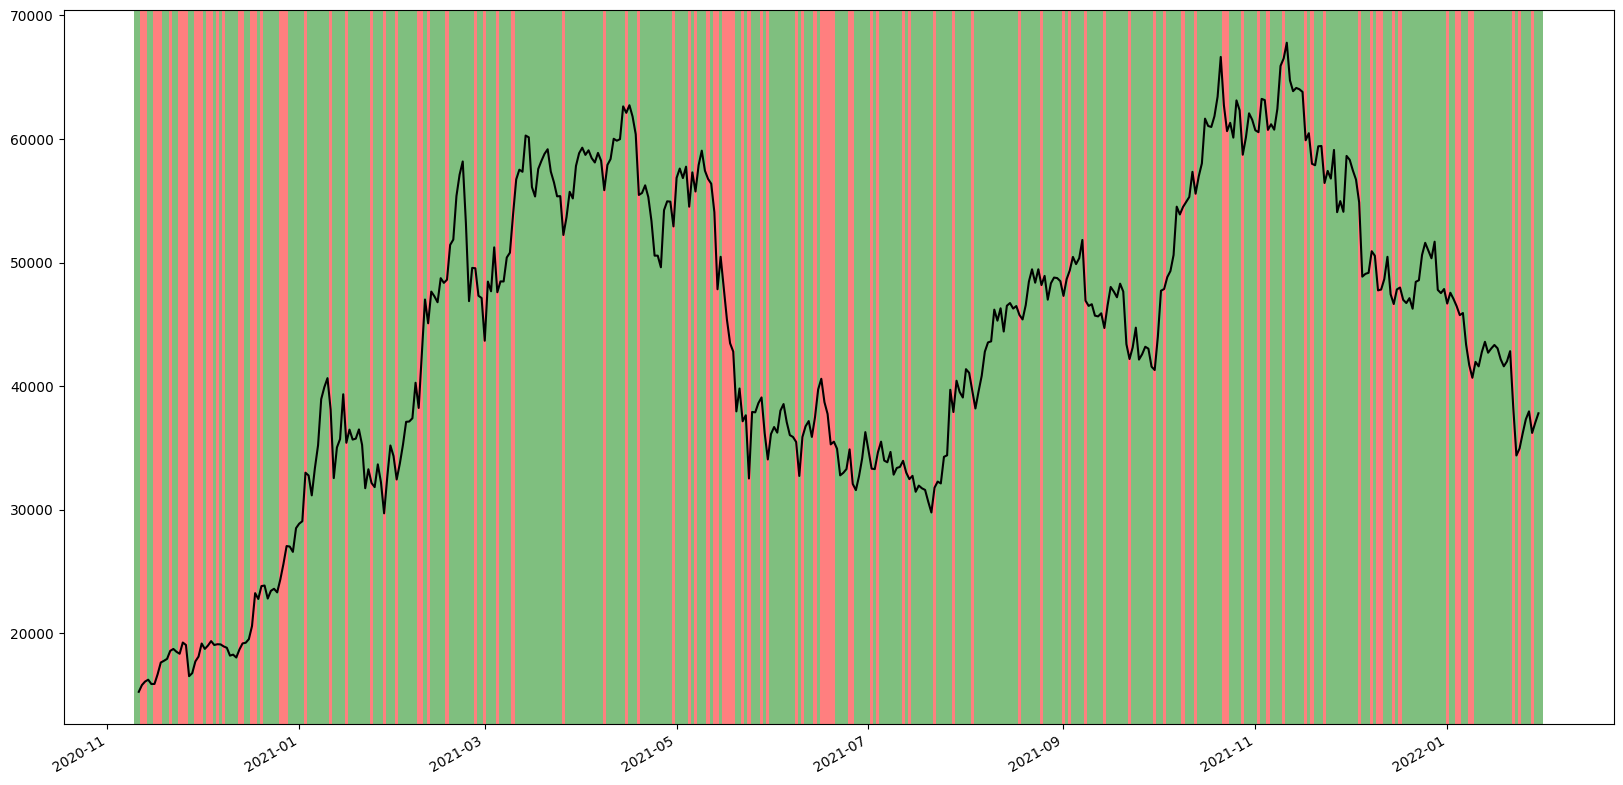

In [21]:
# Visualize predictions
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

df = result.copy()
df = df.resample('D').ffill()

t = mdates.drange(df.index[0], df.index[-1], dt.timedelta(hours=24))
y = np.array(df.Close[:-1])

fig, ax = plt.subplots()
ax.plot_date(t, y, 'b-', color='black')
for i in range(len(df)):
    if df.Predict[i] == 1:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor='red', edgecolor='none', alpha=0.5
        )
    else:
        ax.axvspan(
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) - 0.5,
            mdates.datestr2num(df.index[i].strftime('%Y-%m-%d')) + 0.5,
            facecolor='green', edgecolor='none', alpha=0.5
        )
fig.autofmt_xdate()
fig.set_size_inches(20, 10.5)

In [22]:
backtest = pd.DataFrame(index=result.index)
backtest["r_signal"] = list(test_data["label"])
backtest["p_signal"] = list(result["Predict"])
backtest["m_return"] = list(test_data["close"].pct_change())

backtest["r_signal"] = backtest["r_signal"].replace(0, -1)
backtest["p_signal"] = backtest["p_signal"].replace(0, -1)
backtest["a_return"] = backtest["m_return"] * backtest["r_signal"].shift(1)
backtest["s_return"] = backtest["m_return"] * backtest["p_signal"].shift(1)
backtest[["m_return", "s_return", "a_return"]].cumsum().hist()
backtest[["m_return", "s_return", "a_return"]].cumsum().plot()
plt.show()

NameError: name 'test_data' is not defined